In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt

/home/yunfei/anaconda3/envs/GraphST/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from GraphST import GraphST

In [3]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [4]:
# the number of clusters
n_clusters = 10

In [47]:
# read data
file_fold = '../mBC/' #please replace 'file_fold' with the download path
adata = sc.read_h5ad(file_fold + 'mouse_breast_cancer_sample1_section1_2.h5ad')
adata.var_names_make_unique()

adata.obs

,in_tissue,array_row,array_col,data
AAACAAGTATCTCCCA-11,1,50,102,S1
AAACACCAATAACTGC-11,1,59,19,S1
AAACAGCTTTCAGAAG-11,1,43,9,S1
AAACAGGGTCTATATT-11,1,47,13,S1
AAACCGGGTAGGTACC-11,1,42,28,S1
...,...,...,...,...
TTGTGTATGCCACCAA-13,1,56,60,S3
TTGTGTTTCCCGAAAG-13,1,51,59,S3
TTGTTAGCAAATTCGA-13,1,22,42,S3
TTGTTCAGTGTGCTAC-13,1,24,64,S3


Text(0.5, 1.0, 'Aligned image')

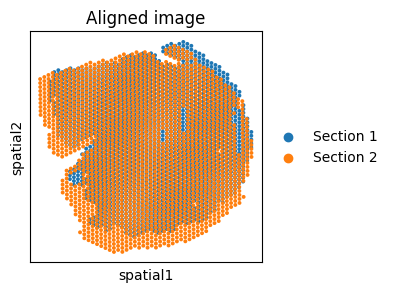

In [22]:
plt.rcParams["figure.figsize"] = (3, 3)
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
ax = sc.pl.embedding(adata, basis='spatial',
                color='data',
                show=False)
ax.set_title('Aligned image')

In [48]:
# define model
model = GraphST.GraphST(adata, device=device)

# run model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:10<00:00, 57.24it/s]

Optimization finished for ST data!


In [49]:
# clustering
from GraphST.utils import clustering

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, method=tool) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, method=tool, start=0.1, end=2.0, increment=0.01)

fitting ...
  |======================================================================| 100%


In [57]:
gt = pd.read_csv(file_fold + 'metadata_sample1_section2.tsv', sep='\t', index_col=0, header=0)
print(gt)

as_list = gt.index.tolist()
new_list = []
for e in as_list:
    e = e + '3'
    new_list.append(e)
# print(new_list)
# idx = as_list.index('Republic of Korea')
# as_list[idx] = 'South Korea'
gt.index = new_list
print(gt)
# adata.obs['original_clusters'] = gt['ground_truth']
# print(adata.obs)
# print(adata.obs.dropna())

                    in_tissue  array_row  array_col  ground_truth
AAACAAGTATCTCCCA-1          1         50        102       Tumor_3
AAACAGAGCGACTCCT-1          1         14         94       Tumor_2
AAACCCGAACGAAATC-1          1         45        115       Tumor_3
AAACCGGGTAGGTACC-1          1         42         28  Tumor_edge_3
AAACCGTTCGTCCAGG-1          1         52         42  Tumor_edge_3
...                       ...        ...        ...           ...
TTGTGTATGCCACCAA-1          1         56         60       Tumor_7
TTGTGTTTCCCGAAAG-1          1         51         59  Tumor_edge_3
TTGTTAGCAAATTCGA-1          1         22         42  Tumor_edge_3
TTGTTCAGTGTGCTAC-1          1         24         64  Tumor_edge_1
TTGTTGTGTGTCAAGA-1          1         31         77       Tumor_6

[1950 rows x 4 columns]
                     in_tissue  array_row  array_col  ground_truth
AAACAAGTATCTCCCA-13          1         50        102       Tumor_3
AAACAGAGCGACTCCT-13          1         14        

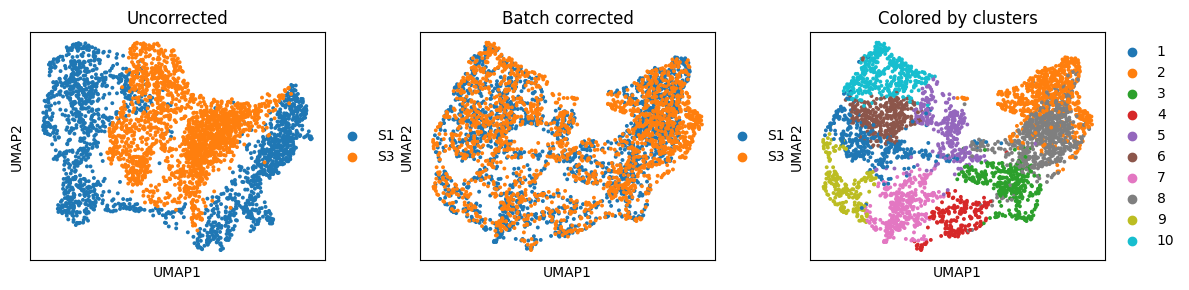

In [52]:
fig, ax_list = plt.subplots(1, 3, figsize=(12, 3))

### Plotting UMAP before batch effect correction
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='data', title='Uncorrected',
                  ax = ax_list[0],
                  show=False)

### Plotting UMAP after batch effect correction
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
           color='data',
           ax=ax_list[1],
           title='Batch corrected',
           #legend_loc = 'bottom margin',
           show=False)

### Color by predicted domains
sc.pl.umap(adata, color='domain', ax=ax_list[2], title='Colored by clusters', show=False)

plt.tight_layout(w_pad=0.02)

In [55]:
print(adata.obs)

                     in_tissue  array_row  array_col data mclust domain
AAACAAGTATCTCCCA-11          1         50        102   S1      9      9
AAACACCAATAACTGC-11          1         59         19   S1      2      2
AAACAGCTTTCAGAAG-11          1         43          9   S1      2      2
AAACAGGGTCTATATT-11          1         47         13   S1      2      2
AAACCGGGTAGGTACC-11          1         42         28   S1      8      8
...                        ...        ...        ...  ...    ...    ...
TTGTGTATGCCACCAA-13          1         56         60   S3      3      3
TTGTGTTTCCCGAAAG-13          1         51         59   S3      8      8
TTGTTAGCAAATTCGA-13          1         22         42   S3      8      8
TTGTTCAGTGTGCTAC-13          1         24         64   S3      3      3
TTGTTGTGTGTCAAGA-13          1         31         77   S3      5      5

[3818 rows x 6 columns]


In [58]:
from sklearn import metrics
## Splitting adata into Section 1 and Section 2
adata_section1 = adata[adata.obs['data']=='S1', :]
adata_section2 = adata[adata.obs['data']=='S3', :]
print(adata_section2.obs)
print(adata_section1.obs)

# gt = gt[gt.index.isin(adata_section2.obs.index.to_list())]
# print(gt)

#fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
#sc.pl.embedding(adata_section1,
#                basis='spatial',
#                color='domain',
#                show = False,
#                s=50,
#                title='Section 1',
#                ax = ax_list[0])

#sc.pl.embedding(adata_section2,
#                basis='spatial',
#                color='domain',
#                show = False,
#                s=50,
#                title = ['Section 2'],
#                ax = ax_list[1])

#plt.tight_layout(w_pad=0.2)

                     in_tissue  array_row  array_col data mclust domain
AAACAAGTATCTCCCA-13          1         50        102   S3      7      7
AAACAGAGCGACTCCT-13          1         14         94   S3     10     10
AAACCCGAACGAAATC-13          1         45        115   S3      9      9
AAACCGGGTAGGTACC-13          1         42         28   S3      2      2
AAACCGTTCGTCCAGG-13          1         52         42   S3      2      2
...                        ...        ...        ...  ...    ...    ...
TTGTGTATGCCACCAA-13          1         56         60   S3      3      3
TTGTGTTTCCCGAAAG-13          1         51         59   S3      8      8
TTGTTAGCAAATTCGA-13          1         22         42   S3      8      8
TTGTTCAGTGTGCTAC-13          1         24         64   S3      3      3
TTGTTGTGTGTCAAGA-13          1         31         77   S3      5      5

[1950 rows x 6 columns]
                     in_tissue  array_row  array_col data mclust domain
AAACAAGTATCTCCCA-11          1         

In [60]:
print(gt)

                     in_tissue  array_row  array_col  ground_truth
AAACAAGTATCTCCCA-13          1         50        102       Tumor_3
AAACAGAGCGACTCCT-13          1         14         94       Tumor_2
AAACCCGAACGAAATC-13          1         45        115       Tumor_3
AAACCGGGTAGGTACC-13          1         42         28  Tumor_edge_3
AAACCGTTCGTCCAGG-13          1         52         42  Tumor_edge_3
...                        ...        ...        ...           ...
TTGTGTATGCCACCAA-13          1         56         60       Tumor_7
TTGTGTTTCCCGAAAG-13          1         51         59  Tumor_edge_3
TTGTTAGCAAATTCGA-13          1         22         42  Tumor_edge_3
TTGTTCAGTGTGCTAC-13          1         24         64  Tumor_edge_1
TTGTTGTGTGTCAAGA-13          1         31         77       Tumor_6

[1950 rows x 4 columns]


In [59]:
print(gt.index.isin(adata_section2.obs.index.to_list()))

[ True  True  True ...  True  True  True]


In [61]:
from sklearn.metrics import adjusted_rand_score

print(adjusted_rand_score(gt['ground_truth'], adata_section2.obs['mclust']))

0.4031275307475078


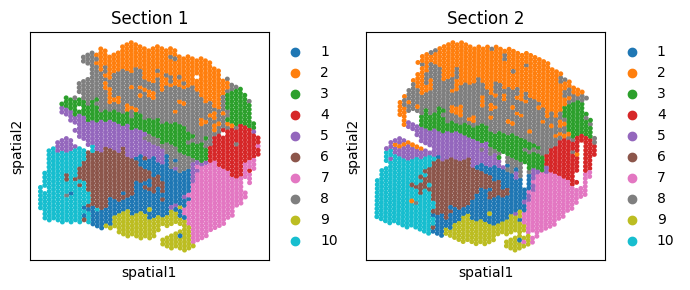

In [62]:
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pl.embedding(adata_section1,
               basis='spatial',
               color='domain',
               show = False,
               s=50,
               title='Section 1',
               ax = ax_list[0])

sc.pl.embedding(adata_section2,
               basis='spatial',
               color='domain',
               show = False,
               s=50,
               title = ['Section 2'],
               ax = ax_list[1])

plt.tight_layout(w_pad=0.2)

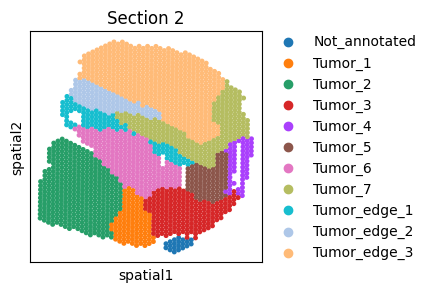

In [66]:
# fig, ax_list = plt.subplots(1, 1, figsize=(3, 3))

adata_section2.obs['original_clusters'] = gt['ground_truth']

sc.pl.embedding(adata_section2,
               basis='spatial',
               color='original_clusters',
               show = False,
               s=50,
               title = ['Section 2'])

plt.show()

### DLPFC